<a href="https://colab.research.google.com/github/Ranjani94/Advanced_Deep_Learning/blob/master/Assignment_3/SimCLR_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SimCLR [A Simple Framework for Contrastive Learning of Visual Representation]

A massive number of unannotate images are produced in the current world and the cost to annotate them is so expensive. To overcome this problem, SimCLR is introduced where the good representations are learned from the unlabeled data instead of supervised data. This would definitely help to extract the downstream task which has limited annotated data and also proved state-of-the-art accuracy. The idea of Contrastive learning to learn the representations while enforcing similar elements to be equal and dissimilar elements to be different. 

SimCLR uses ResNet50 pre trained model as a backbone. The ResNet model is fed with augmented images of shape (224,224,3) and it outputs a 2048 dimensional embeddign vector. A Multilayer perceptron with two dense layers is applied to the embedding vectoe which produces the final representation. After the training, we can delete the projection head whihc is MLP and use only the representations to learn the new downstream task.

### Importing necessary libraries

In [1]:
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds


### Load pretrained/finetuned SimCLR models from checkpoints or hub modules

In [6]:
def count_params(checkpoint, excluding_vars=[], verbose=True):
  vdict = checkpoint.get_variable_to_shape_map()
  cnt = 0
  for name, shape in vdict.items():
    skip = False
    for evar in excluding_vars:
      if re.search(evar, name):
        skip = True
    if skip:
      continue
    if verbose:
      print(name, shape)
    cnt += np.prod(shape)
  cnt = cnt / 1e6
  print("Total number of parameters: {:.2f}M".format(cnt))
  return cnt

checkpoint_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/'
checkpoint = tf.train.load_checkpoint(checkpoint_path)
_ = count_params(checkpoint, excluding_vars=['global_step', "Momentum", 'ema', 'memory', 'head'], verbose=False)

Total number of parameters: 23.56M


### Loading hub modules from Google cloud platform

https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/pretrained;tab=objects?pli=1&prefix=&forceOnObjectsSortingFiltering=false

In [7]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

--2020-09-27 00:23:24--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2020-09-27 00:23:24 (116 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



###Functions for Preprocessing the images

In [8]:
FLAGS_color_jitter_strength = 0.3
CROP_PROPORTION = 0.875  # Standard for ImageNet.


def random_apply(func, p, x):
  return tf.cond(
      tf.less(tf.random_uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)

### Applying random_brightness function to change the brightness of the image.

In [9]:
def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative vs additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random_uniform(
        [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image

### Applying Grayscale to apply the color transformation on images

In [10]:
def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image

### Color_jitter function will change the color of the image

In [11]:
def color_jitter(image,
                 strength,
                 random_order=True):
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(image, brightness, contrast, saturation, hue)
  else:
    return color_jitter_nonrand(image, brightness, contrast, saturation, hue)

In [12]:
def color_jitter_nonrand(image, brightness=0, contrast=0, saturation=0, hue=0):
  with tf.name_scope('distort_color'):
    def apply_transform(i, x, brightness, contrast, saturation, hue):
      """Apply the i-th transformation."""
      if brightness != 0 and i == 0:
        x = random_brightness(x, max_delta=brightness)
      elif contrast != 0 and i == 1:
        x = tf.image.random_contrast(
            x, lower=1-contrast, upper=1+contrast)
      elif saturation != 0 and i == 2:
        x = tf.image.random_saturation(
            x, lower=1-saturation, upper=1+saturation)
      elif hue != 0:
        x = tf.image.random_hue(x, max_delta=hue)
      return x

    for i in range(4):
      image = apply_transform(i, image, brightness, contrast, saturation, hue)
      image = tf.clip_by_value(image, 0., 1.)
    return image

In [13]:
def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      """Apply the i-th transformation."""
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness)
      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random_shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image

### Applying compute_crop_shape to crop the image by passing parameters height, width, aspect_ratio and crop proportion

In [14]:

def _compute_crop_shape(image_height, image_width, aspect_ratio, crop_proportion):
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(tf.rint(
        crop_proportion / aspect_ratio * image_width_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * aspect_ratio *
        image_height_float), tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)

### Center_crop function is used the crop the image with specific height, proportion and width of the image

In [15]:
def center_crop(image, height, width, crop_proportion):
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, height / width, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.image.resize_bicubic([image], [height, width])[0]

  return image

In [16]:
def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image

### crop and resize function will crop the given image and resize them to original shape

In [17]:
def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.
  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.
  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize_bicubic([image], [height, width])[0]

### Gaussian Blur will help to see more clearly into the image and much useful for image classification task

In [18]:
def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  radius = tf.to_int32(kernel_size / 2)
  kernel_size = radius * 2 + 1
  x = tf.to_float(tf.range(-radius, radius + 1))
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.to_float(sigma), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred

In [19]:
def random_crop_with_resize(image, height, width, p=1.0):
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)

In [20]:
def random_color_jitter(image, p=1.0):
  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=FLAGS_color_jitter_strength)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)

In [21]:
def random_blur(image, height, width, p=1.0):
  del width
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//10, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)

In [22]:
def batch_random_blur(images_list, height, width, blur_probability=0.5):
  def generate_selector(p, bsz):
    shape = [bsz, 1, 1, 1]
    selector = tf.cast(
        tf.less(tf.random_uniform(shape, 0, 1, dtype=tf.float32), p),
        tf.float32)
    return selector

  new_images_list = []
  for images in images_list:
    images_new = random_blur(images, height, width, p=1.)
    selector = generate_selector(blur_probability, tf.shape(images)[0])
    images = images_new * selector + images * (1 - selector)
    images = tf.clip_by_value(images, 0., 1.)
    new_images_list.append(images)

  return new_images_list

In [23]:
def preprocess_for_train(image, height, width,
                         color_distort=True, crop=True, flip=True):
  if crop:
    image = random_crop_with_resize(image, height, width)
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image

In [24]:
def preprocess_for_eval(image, height, width, crop=True):
  if crop:
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image

In [25]:
def preprocess_image(image, height, width, is_training=False,
                     color_distort=True, test_crop=True):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if is_training:
    return preprocess_for_train(image, height, width, color_distort)
  else:
    return preprocess_for_eval(image, height, width, test_crop)

### Loading the tensorflow flower dataset

In [26]:
batch_size = 64
dataset_name = 'tf_flowers'

tfds_dataset, tfds_info = tfds.load(
    dataset_name, split='train', with_info=True)
num_images = tfds_info.splits['train'].num_examples
num_classes = tfds_info.features['label'].num_classes

###Calling the preprocess_image function to apply the necessary transformation on the images

In [27]:
def _preprocess(x):
  x['image'] = preprocess_image(x['image'], 224, 224, is_training=False, color_distort=False)
  return x
x = tfds_dataset.map(_preprocess).batch(batch_size)
x = tf.data.make_one_shot_iterator(x).get_next()

### Loading the modeule and getting the computation graph

In [28]:

hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'
module = hub.Module(hub_path, trainable=False)
key = module(inputs=x['image'], signature="default", as_dict=True)
logits_t = key['logits_sup'][:, :]
key # The accessible tensor in the return dictionary

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


{'block_group1': <tf.Tensor 'module_apply_default/base_model/block_group1:0' shape=(None, 56, 56, 256) dtype=float32>,
 'block_group2': <tf.Tensor 'module_apply_default/base_model/block_group2:0' shape=(None, 28, 28, 512) dtype=float32>,
 'block_group3': <tf.Tensor 'module_apply_default/base_model/block_group3:0' shape=(None, 14, 14, 1024) dtype=float32>,
 'block_group4': <tf.Tensor 'module_apply_default/base_model/block_group4:0' shape=(None, 7, 7, 2048) dtype=float32>,
 'default': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'final_avg_pool': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'initial_conv': <tf.Tensor 'module_apply_default/base_model/initial_conv:0' shape=(None, 112, 112, 64) dtype=float32>,
 'initial_max_pool': <tf.Tensor 'module_apply_default/base_model/initial_max_pool:0' shape=(None, 56, 56, 64) dtype=float32>,
 'logits_sup': <tf.Tensor 'module_apply_default/head_

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Predictions

In [30]:
image, labels, logits = sess.run((x['image'], x['label'], logits_t))
pred = logits.argmax(-1)

### Plotting the images after prediction

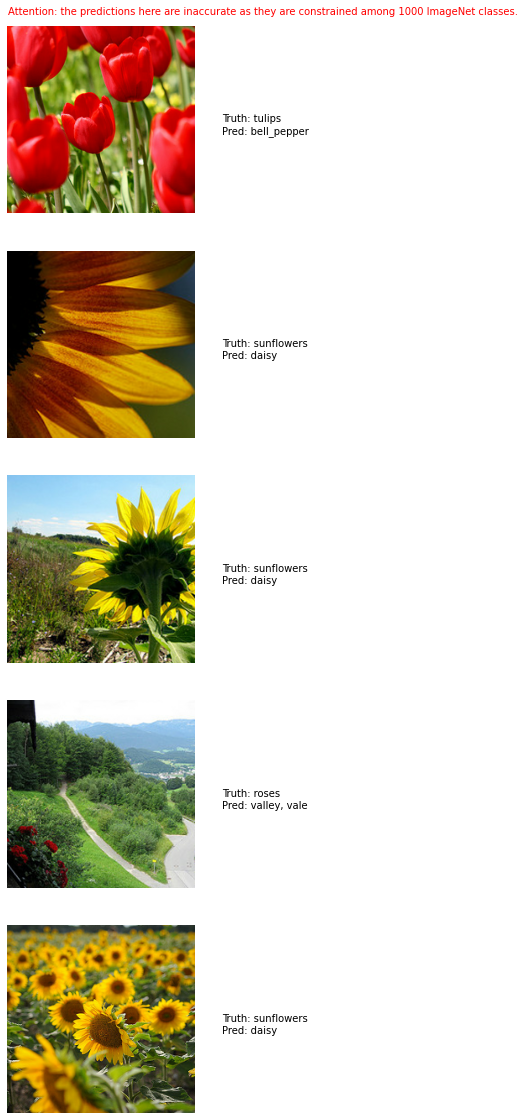

In [34]:
fig, axes = plt.subplots(5, 1, figsize=(20, 20))
for i in range(5):
  axes[i].imshow(image[i])
  true_text = tf_flowers_labels[labels[i]]
  pred_text = imagenet_int_to_str[pred[i]]
  if i == 0:
    axes[i].text(0, 0, 'Attention: the predictions here are inaccurate as they are constrained among 1000 ImageNet classes.\n', c='r')
  axes[i].axis('off')
  axes[i].text(256, 128, 'Truth: ' + true_text + '\n' + 'Pred: ' + pred_text)

## Comparing the results with the regular ResNet50 model without using SimCLR

Loading pretrained model

In [35]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


### Loading flower dataset from tensorflow

In [36]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [37]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [38]:
do_fine_tuning = False #@param {type:"boolean"}

### Defining the model

In [39]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

### Training the model

In [41]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - ETA: 0s - batch: 45.0000 - size: 31.9451 - loss: 0.9199 - accuracy: 0.7551WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


91/91 [==============================] - 16s 177ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.9199 - accuracy: 0.7551 - val_loss: 0.7232 - val_accuracy: 0.8608
Epoch 2/5
91/91 [==============================] - 16s 180ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.6912 - accuracy: 0.8772 - val_loss: 0.7034 - val_accuracy: 0.8651
Epoch 3/5
91/91 [==============================] - 16s 180ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.6498 - accuracy: 0.8992 - val_loss: 0.6838 - val_accuracy: 0.8778
Epoch 4/5
91/91 [==============================] - 16s 181ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.6243 - accuracy: 0.9185 - val_loss: 0.6780 - val_accuracy: 0.8821
Epoch 5/5
91/91 [==============================] - 16s 178ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.6072 - accuracy: 0.9295 - val_loss: 0.6860 - val_accuracy: 0.8849


### Plottign results after predictions

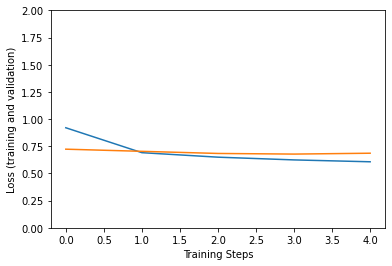

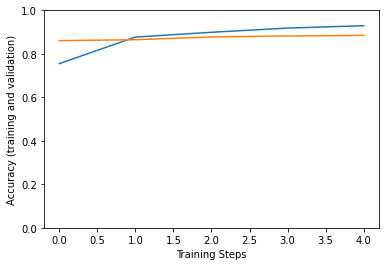

In [42]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

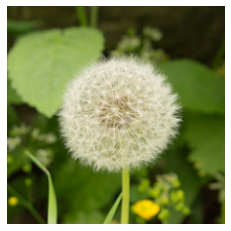

True label: dandelion
Predicted label: dandelion


In [49]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[10, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

The predictions by SimCLR which uses contrastive based techniques for extracting visual representations are reaching the same level of those learbed through supervised methods. In SimCLR since we used only 1000 images from ImageNet as training takes more time and yet it was able to predict as near as supervised.